In [1]:
import os
import numpy as np
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from geo_utils import table_dict
from sqlalchemy import create_engine, text

In [64]:
import geopandas as gpd
from rasterio import features
from rasterio.transform import from_origin

In [2]:
load_dotenv('./conf.env')
conn_str = os.getenv('CONN_STR')
engine = create_engine(conn_str)

In [3]:
time = datetime.strptime('2022_05_26T17_50_14_786', '%Y_%m_%dT%H_%M_%S_%f')

In [74]:
query = "SELECT shape FROM {} WHERE time='{}'"

In [80]:
per_class_maps = dict()
width, height = 3454, 3454 

In [82]:
with engine.connect() as conn:
    for pixel_value, table in table_dict.items():
        f_query = query.format(table, time)
        gdf = gpd.read_postgis(f_query, engine, geom_col='shape')
        minx, miny, maxx, maxy = gdf.total_bounds
        transform = from_origin(minx, maxy, (maxx - minx) / width, (maxy - miny) / height)
        raster = np.zeros((height, width), dtype=np.uint8)
        for geometry in gdf.geometry:
            burned = features.rasterize(
                [(geometry, 1)],
                out=raster,
                transform=transform,
                all_touched=True,
                dtype='uint8'
            )
            raster = np.maximum(raster, burned)
        per_class_maps[pixel_value] = raster


0 [0 1]
1 [0 1]
2 [0 1]
3 [0 1]
4 [0 1]


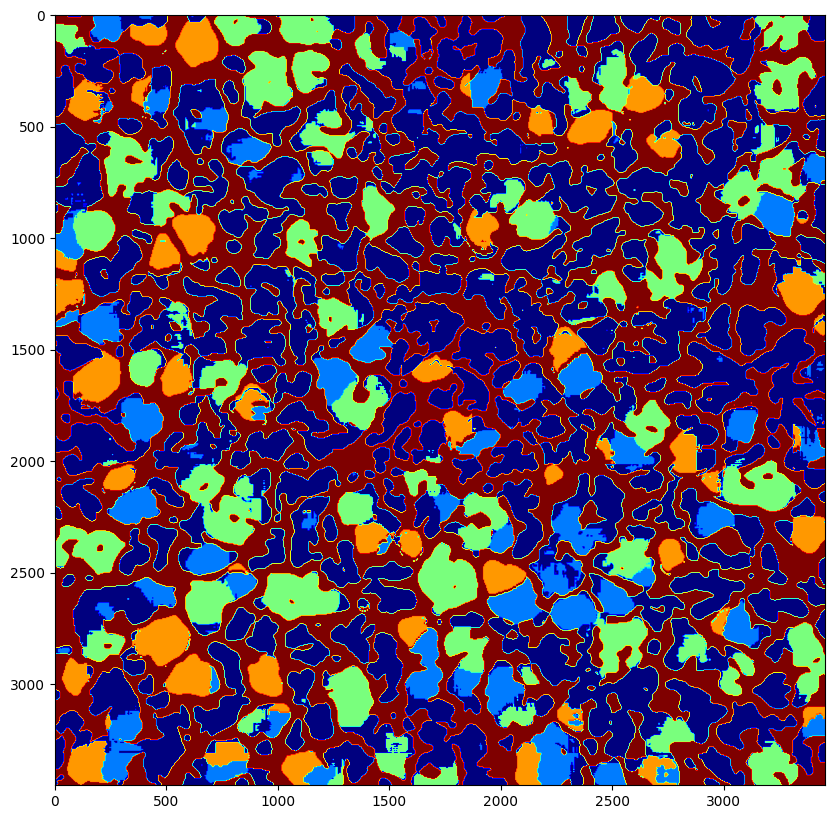

In [87]:
final_map = np.full((width, height), 0, np.uint8)
for pixel_value, raster in per_class_maps.items():
    print(pixel_value, np.unique(raster))
    final_map[raster==1] = pixel_value
# print(np.unique(final_map))
plt.figure(figsize=(10, 10))
plt.imshow(final_map, cmap='jet_r')